# GCNのデモンストレーション
- Graph Neural Network(GCN)
- Coraネットワークを利用してリンク予測をする

GPUの動作確認

In [15]:
import sys
import torch

print("Python：" + sys.version)
print("PyTorch：" + torch.__version__)

if torch.cuda.is_available():
    print("CUDA：" + torch.version.cuda)
    print("GPU：" + torch.cuda.get_device_name(0))
else:
    print("GPU is not available.")

Python：3.12.11 (main, Aug 19 2025, 12:03:11) [GCC 11.4.0]
PyTorch：2.8.0+cu128
CUDA：12.8
GPU：NVIDIA GeForce RTX 3060


## データの取得

- CORAネットワーク
    - 論文索引関係を表すネットワーク

### 取得したCoraデータを変換

- CoraのテストデータをPyTorchのデータ型に変換
- 変換したデータ分割する

In [57]:
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import RandomLinkSplit

# Cora の citation ネットワーク (2,708 ノード / 5,429 エッジ)
data = Planetoid(root='/tmp', name='Cora')[0]
data.train_mask = data.val_mask = data.test_mask = None

# エッジをトレーニング、検証、テストセットに分割
transform = RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

# データセットの情報を表示
print(f"TRAIN      node num: {train_data.x.size(0)}, edge num: {train_data.edge_index.size(1)}, node feature num: {train_data.num_node_features}")
print(f"VALIDATION node num: {val_data.x.size(0)}, edge num: {val_data.edge_index.size(1)}, node feature num: {val_data.num_node_features}")
print(f"TEST       node num: {test_data.x.size(0)}, edge num: {test_data.edge_index.size(1)}, node feature num: {test_data.num_node_features}")

TRAIN      node num: 2708, edge num: 8448, node feature num: 1433
VALIDATION node num: 2708, edge num: 8448, node feature num: 1433
TEST       node num: 2708, edge num: 9502, node feature num: 1433


### 取得したデータの可視化

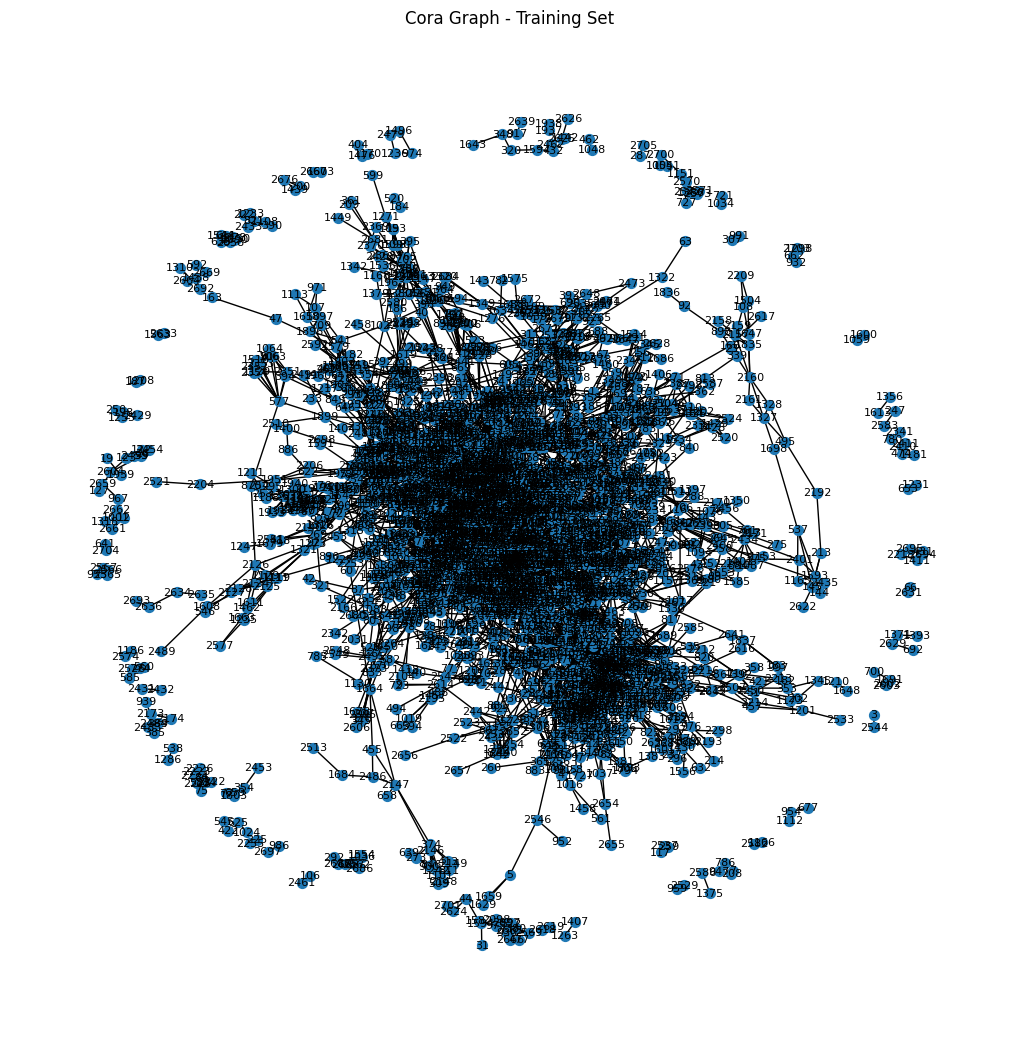

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

train_graph = nx.Graph()
train_graph.add_edges_from(train_data.edge_index.t().tolist())

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(train_graph)
nx.draw(train_graph, pos, with_labels=True, node_size=50, font_size=8)
plt.title("Cora Graph - Training Set")
plt.show()

## GCNを活用したリンク予測
- Graph Convolution Network(GCN)
- リンク予測：グラフにおける既存のエッジから新たなエッジを予測する

### GCNモデルの定義


In [4]:
from torch import nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [52]:
# モデルの初期化
in_channels = train_data.num_node_features  # 特徴量の数
out_channels = 8  # 出力の次元数
model = GCN(in_channels, out_channels)
print(f"入力特徴量の次元: {in_channels}, 出力特徴量の次元: {out_channels}")
print(model)

# モデルとデータをデバイスに転送
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

入力特徴量の次元: 1433, 出力特徴量の次元: 8
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 8)
)


### モデルの学習
- 学習タスク: 2値分類を利用したリンク予測
- パラメータの更新: Adam
- 目的関数
    - バイナリークロスエントロピー: binary_cross_entropy_with_logits 

**2値分類のリンク予測**
- ノードに対してエッジが接続される確率とエッジが接続されない確率の2値をを予測する
- 2値分類(エッジが接続される場合とエッジが接続されない場合)を応用することでリンク予測をする
- 正負のエッジ
    - 正のエッジ: エッジが接続されるい確率
    - 負のエッジ: エッジが接続されない確率

In [ ]:
from torch_geometric.utils import negative_sampling

# 学習回数と最適化手法の設定
epoch_num = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# モデルの学習
model.train()
for epoch in range(1, epoch_num + 1):
    # 勾配の初期化
    optimizer.zero_grad()
    
    # モデルの出力
    out = model(train_data.x, train_data.edge_index)

    # 正のエッジをサンプリング
    num_pos_edges = train_data.edge_index.size(1)
    pos_edge_index = train_data.edge_index[:, :num_pos_edges]

    # 正のエッジのノード埋め込みを取得
    edge_embeddings_src = out[pos_edge_index[0]] # 始点ノードの埋め込み
    edge_embeddings_dst = out[pos_edge_index[1]] # 終点ノードの埋め込み
    pos_scores = torch.sum(edge_embeddings_src * edge_embeddings_dst, dim=1) # 内積でエッジの存在確率を計算
    
    # 負のエッジをサンプリング
    num_neg_edges = train_data.edge_index.size(1)
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    
    # 負のエッジのノード埋め込みを取得
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    
    # スコアを結合
    scores = torch.cat([pos_scores, neg_scores])

    # 正解ラベルを作成
    pos_labels = torch.ones(pos_scores.size(0), device=device)  # 正のエッジ(1)の数だけラベルを作成
    neg_labels = torch.zeros(neg_scores.size(0), device=device)  # 負のエッジ(0)の数だけラベルを作成
    labels = torch.cat([pos_labels, neg_labels])  # ラベルを結合
    
    # 損失計算（バイナリクロスエントロピー）
    loss = F.binary_cross_entropy_with_logits(scores, labels) # ロジット(sigmoid関数)を使用して損失を計算
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 0.4382
Epoch 20, Loss: 0.4379
Epoch 30, Loss: 0.4346
Epoch 40, Loss: 0.4372
Epoch 50, Loss: 0.4339
Epoch 60, Loss: 0.4344
Epoch 70, Loss: 0.4391
Epoch 80, Loss: 0.4373
Epoch 90, Loss: 0.4365
Epoch 100, Loss: 0.4356


### モデルの評価
- ROC曲線
- AUCスコア
- Accuracy

**検証データ**

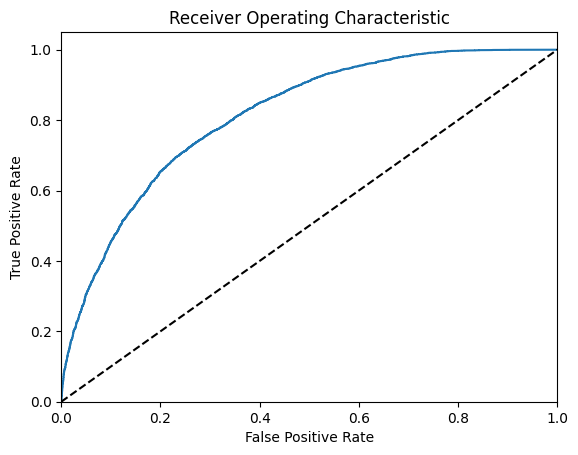

AUC Score: 0.8133
Accuracy: 0.7326
Optimal Threshold: 0.5055
Positive edge predictions (mean): 0.5095
Negative edge predictions (mean): 0.5038


In [55]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve

# 学習済みモデルでリンク予測を実行
model.eval()
with torch.no_grad():
    # 検証データでの予測
    out = model(val_data.x, val_data.edge_index)
    
    # 検証データで正のエッジでの予測
    pos_edge_index = val_data.edge_index
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)

    # 検証データで負のエッジでの予測
    neg_edge_index = negative_sampling(
        edge_index=val_data.edge_index,
        num_nodes=val_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)
    
    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy()

    # 正解ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels])

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    
    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    # Youden's J statisticを利用して最適な閾値を決定
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]

    # 最適な閾値を用いてAccuracyの計算
    binary_predictions = (predictions > optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)

    # ROC曲線をプロット
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # AUCスコアと分類精度を表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

**テストデータ**

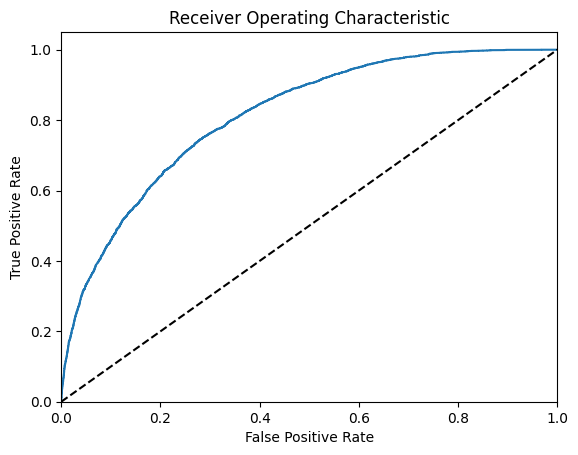

AUC Score: 0.8127
Accuracy: 0.5730
Optimal Threshold: 0.5055
Positive edge predictions (mean): 0.5092
Negative edge predictions (mean): 0.5037


In [56]:
# 学習済みモデルでリンク予測を実行
model.eval()
with torch.no_grad():
    # テストデータでの予測
    out = model(test_data.x, test_data.edge_index)

    # テストデータで正のエッジでの予測
    pos_edge_index = test_data.edge_index
    pos_embeddings_src = out[pos_edge_index[0]]
    pos_embeddings_dst = out[pos_edge_index[1]]
    pos_scores = torch.sum(pos_embeddings_src * pos_embeddings_dst, dim=1)
    pos_pred = torch.sigmoid(pos_scores)

    # テストデータで負のエッジでの予測
    neg_edge_index = negative_sampling(
        edge_index=test_data.edge_index,
        num_nodes=test_data.num_nodes,
        num_neg_samples=num_neg_edges
    )
    neg_embeddings_src = out[neg_edge_index[0]]
    neg_embeddings_dst = out[neg_edge_index[1]]
    neg_scores = torch.sum(neg_embeddings_src * neg_embeddings_dst, dim=1)
    neg_pred = torch.sigmoid(neg_scores)
    
    # 予測結果をまとめる
    predictions = torch.cat([pos_pred, neg_pred]).cpu().numpy()

    # 正解ラベルを作成
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    labels = torch.cat([pos_labels, neg_labels])

    # AUCスコアを計算
    auc_score = roc_auc_score(labels, predictions)
    
    # 0.5を閾値として分類精度を計算
    binary_predictions = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(labels, binary_predictions)

    # ROC曲線をプロット
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], 'k--')  # ランダム予測の線
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.show()

    # AUCスコアと分類精度を表示
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Positive edge predictions (mean): {pos_pred.mean().item():.4f}")
    print(f"Negative edge predictions (mean): {neg_pred.mean().item():.4f}")

### グラフの可視化

- 予測前のグラフと予測後のグラフを可視化し比較する

予測された正のエッジ数: 9500
有効な予測エッジ数: 9500


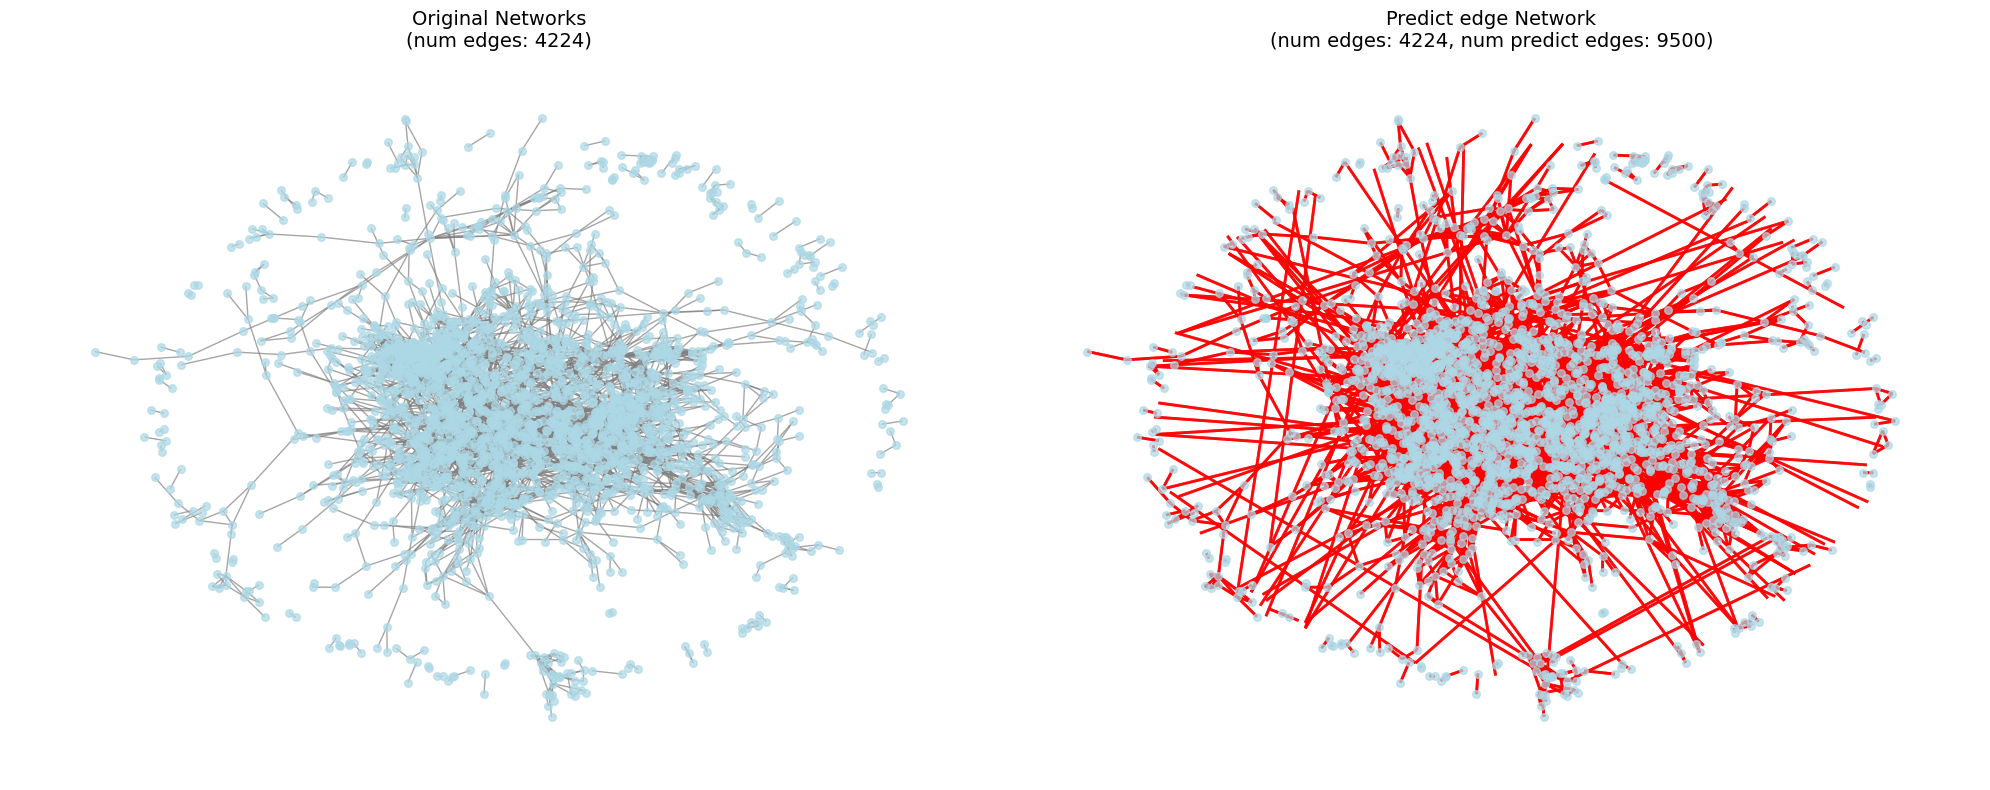


=== 予測結果サマリー ===
閾値 0.5 以上の予測エッジ数: 9500
有効な予測エッジ数: 9500
全テスト正エッジ数: 9502


In [ ]:
import matplotlib.pyplot as plt

# 予測されたエッジを取得（閾値0.5以上のもの）
threshold = 0.5
predicted_edges = []

# 正のエッジの予測結果から閾値以上のものを取得
for i, score in enumerate(pos_pred.cpu().numpy()):
    if score >= threshold:
        edge = test_data.edge_index[:, i].cpu().numpy()
        predicted_edges.append((edge[0], edge[1]))

print(f"予測された正のエッジ数: {len(predicted_edges)}")

# 元のトレーニングエッジでグラフを作成
G_original = nx.Graph()
G_original.add_edges_from(train_data.edge_index.t().cpu().numpy())

# 全ノードを含むグラフを作成（孤立ノードも含む）
G_full = nx.Graph()
G_full.add_nodes_from(range(data.num_nodes))  # 全ノードを追加
G_full.add_edges_from(train_data.edge_index.t().cpu().numpy())

# レイアウトを全ノードで計算
pos = nx.spring_layout(G_full, seed=42)

# 予測エッジのうち、レイアウトに存在するもののみをフィルタリング
valid_predicted_edges = []
for edge in predicted_edges:
    if edge[0] in pos and edge[1] in pos:
        valid_predicted_edges.append(edge)

print(f"有効な予測エッジ数: {len(valid_predicted_edges)}")

# 可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# 元のネットワーク
nx.draw(G_original, pos, ax=ax1, with_labels=False, node_size=30, 
        node_color='lightblue', edge_color='gray', alpha=0.7)
ax1.set_title(f"Original Networks\n(num edges: {G_original.number_of_edges()})", fontsize=14)

# 予測エッジを追加したネットワーク
nx.draw(G_original, pos, ax=ax2, with_labels=False, node_size=30, 
        node_color='lightblue', edge_color='gray', alpha=0.7)

# 有効な予測エッジのみを赤色で追加
if valid_predicted_edges:
    nx.draw_networkx_edges(G_full, pos, edgelist=valid_predicted_edges, 
                          ax=ax2, edge_color='red', width=2, alpha=0.8)

ax2.set_title(f"Predict edge Network\n(num edges: {G_original.number_of_edges()}, num predict edges: {len(valid_predicted_edges)})", fontsize=14)

plt.tight_layout()
plt.show()

# 予測精度の詳細表示
print(f"\n=== 予測結果サマリー ===")
print(f"閾値 {threshold} 以上の予測エッジ数: {len(predicted_edges)}")
print(f"有効な予測エッジ数: {len(valid_predicted_edges)}")
print(f"全テスト正エッジ数: {len(pos_pred)}")